## RNN for Skyrmion trajectories prediction

**Imports**

In [1]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(20, 10))
mpl.rc('image', cmap='gray')

import trackpy as tp

from tqdm import tqdm  # for progress bar

import tensorflow as tf

**Read the data**

In [2]:
directory = 'Rec_EDGE_300K_1L_50MA.out'

data = pd.read_csv(directory + '/trajectories.csv')
data.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,0,24.420047,61.809992,33.895088,3.785002,0.048289,0.451671,91.250977,0.000493,0,0
1,1,31.518261,109.009463,33.850101,3.792741,0.067499,0.455270,91.282349,0.000493,0,1
2,2,51.658864,41.007417,34.208199,3.811746,0.062159,0.449871,92.517654,0.000486,0,2
3,3,60.994689,82.173861,34.559098,3.818268,0.046138,0.455270,93.368622,0.000482,0,3
4,4,61.572998,129.252586,33.747531,3.807508,0.059245,0.453470,91.835289,0.000490,0,4


**Drop the unused columns**

In [3]:
unused_columns = ['Unnamed: 0', 'mass', 'size', 'ecc', 'signal', 'raw_mass', 'ep']

data = data.drop(columns=unused_columns)
data.head()

,y,x,frame,particle
0,24.420047,61.809992,0,0
1,31.518261,109.009463,0,1
2,51.658864,41.007417,0,2
3,60.994689,82.173861,0,3
4,61.572998,129.252586,0,4


**Fill in missing values with average positions (if a skyrmion is missing for more than one frame, it might not be very precise, but it should not be a big issue here)**

In [4]:
no_skyrmions = data[data['frame'] == 0].shape[0]
no_skyrmions

15

In [5]:
# ids of initial particles
ids = list(range(no_skyrmions))

# iterate through the frames
for f in tqdm(data['frame'].unique()):
    for p in range(no_skyrmions):
        # this means the skyrmion p is missing in frame f
        if not any(data[data['frame'] == f]['particle'] == p):
            
            # find previous coorinates
            x_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['x'].values[0]
            y_prev = data[(data['frame'] == f-1) & (data['particle'] == p)]['y'].values[0]
            
            x_next = x_prev
            y_next = y_prev
            
            #find next coordinates
            for next_frame in range((f+1).astype(int), len(data['frame'].unique())):
                if any(data[data['frame'] == f]['particle'] == p):
                    x_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['x'].values[0]
                    y_next = data[(data['frame'] == next_frame) & (data['particle'] == p)]['y'].values[0]
                    break
                    
            # new coordinates
            x_new = (x_prev + x_next) / 2
            y_new = (y_prev + y_next) / 2
            
            data = data.append({'y' : y_new,
                                'x' : x_new,
                                'frame' : f,
                                'particle': p}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 54.07it/s]


In [6]:
data = data.sort_values(by=['frame', 'particle'])

In [7]:
data

,y,x,frame,particle
0,24.420047,61.809992,0.0,0.0
1,31.518261,109.009463,0.0,1.0
2,51.658864,41.007417,0.0,2.0
3,60.994689,82.173861,0.0,3.0
4,61.572998,129.252586,0.0,4.0
...,...,...,...,...
11922,26.838018,9158.734705,799.0,10.0
11927,92.153535,8909.539660,799.0,11.0
11935,160.675052,8812.401110,799.0,12.0
11934,156.663224,8600.194927,799.0,13.0


**Check that there are no more missing values**

In [8]:
for f in tqdm(data['frame'].unique()):
    if (data[data['frame'] == f]['particle'].shape[0] < no_skyrmions):
        print(f)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 3015.57it/s]


**Data in df so that every column is one coordinate for every particle**

In [9]:
df = pd.DataFrame()

for i in range(no_skyrmions):
    df['x' + str(i)] = data[data['particle'] == i]['x'].tolist()
    df['y' + str(i)] = data[data['particle'] == i]['y'].tolist()
df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,61.809992,24.420047,109.009463,31.518261,41.007417,51.658864,82.173861,60.994689,129.252586,61.572998,...,149.187062,132.051286,72.301194,146.781910,109.212794,161.979373,31.206029,171.620268,72.360366,180.180794
1,70.800099,22.786106,115.034451,27.359058,56.770645,48.881918,93.903291,63.388959,142.176403,68.743495,...,155.410027,136.726409,84.874560,147.080992,116.677109,164.041669,41.597807,172.882005,84.455856,180.965200
2,78.538462,23.797221,130.692766,28.694485,69.754244,49.195767,104.248682,62.628843,149.435504,63.558705,...,172.709568,137.821583,94.857647,150.303890,127.577917,162.563253,53.489143,172.916823,95.782669,180.334193
3,92.436819,22.500377,141.306599,28.509058,75.410123,55.660198,116.317274,57.199332,164.570299,65.745704,...,181.676744,140.120606,105.774022,152.146324,130.526388,160.038652,65.796451,173.630391,99.542822,181.777237
4,104.597821,22.045133,153.672323,32.607063,88.264549,57.453459,130.591005,60.657274,179.266999,69.602374,...,189.526628,139.423639,113.377728,151.868048,144.434838,157.801565,75.483587,167.356819,114.508108,180.704282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,8981.526291,162.759434,8905.468947,65.666374,8776.246745,81.841453,8889.580339,131.603677,9006.991341,81.713527,...,9109.700746,26.452611,8865.460749,87.527381,8765.499382,159.460524,8558.890750,143.787322,8645.328271,95.430345
796,8990.157367,162.037060,8920.939120,68.184222,8783.443636,82.635062,8905.581351,133.414790,9016.424345,80.574345,...,9118.240007,31.882422,8870.262045,89.777329,8779.673772,157.102168,8564.491667,148.493380,8656.947572,97.473753
797,9007.540353,162.559788,8926.055087,67.701657,8791.222714,82.034506,8915.689062,128.354733,9028.391936,82.429318,...,9134.451840,30.151817,8889.806349,87.506576,8795.790768,156.124812,8570.426668,148.497985,8662.395565,94.621296
798,9017.586395,165.976863,8941.781486,64.043311,8801.224151,79.495828,8922.590396,133.696989,9042.898201,76.606256,...,9150.591007,26.007648,8896.582583,96.559651,8795.341502,153.007862,8584.067513,155.449980,8670.683702,96.324460


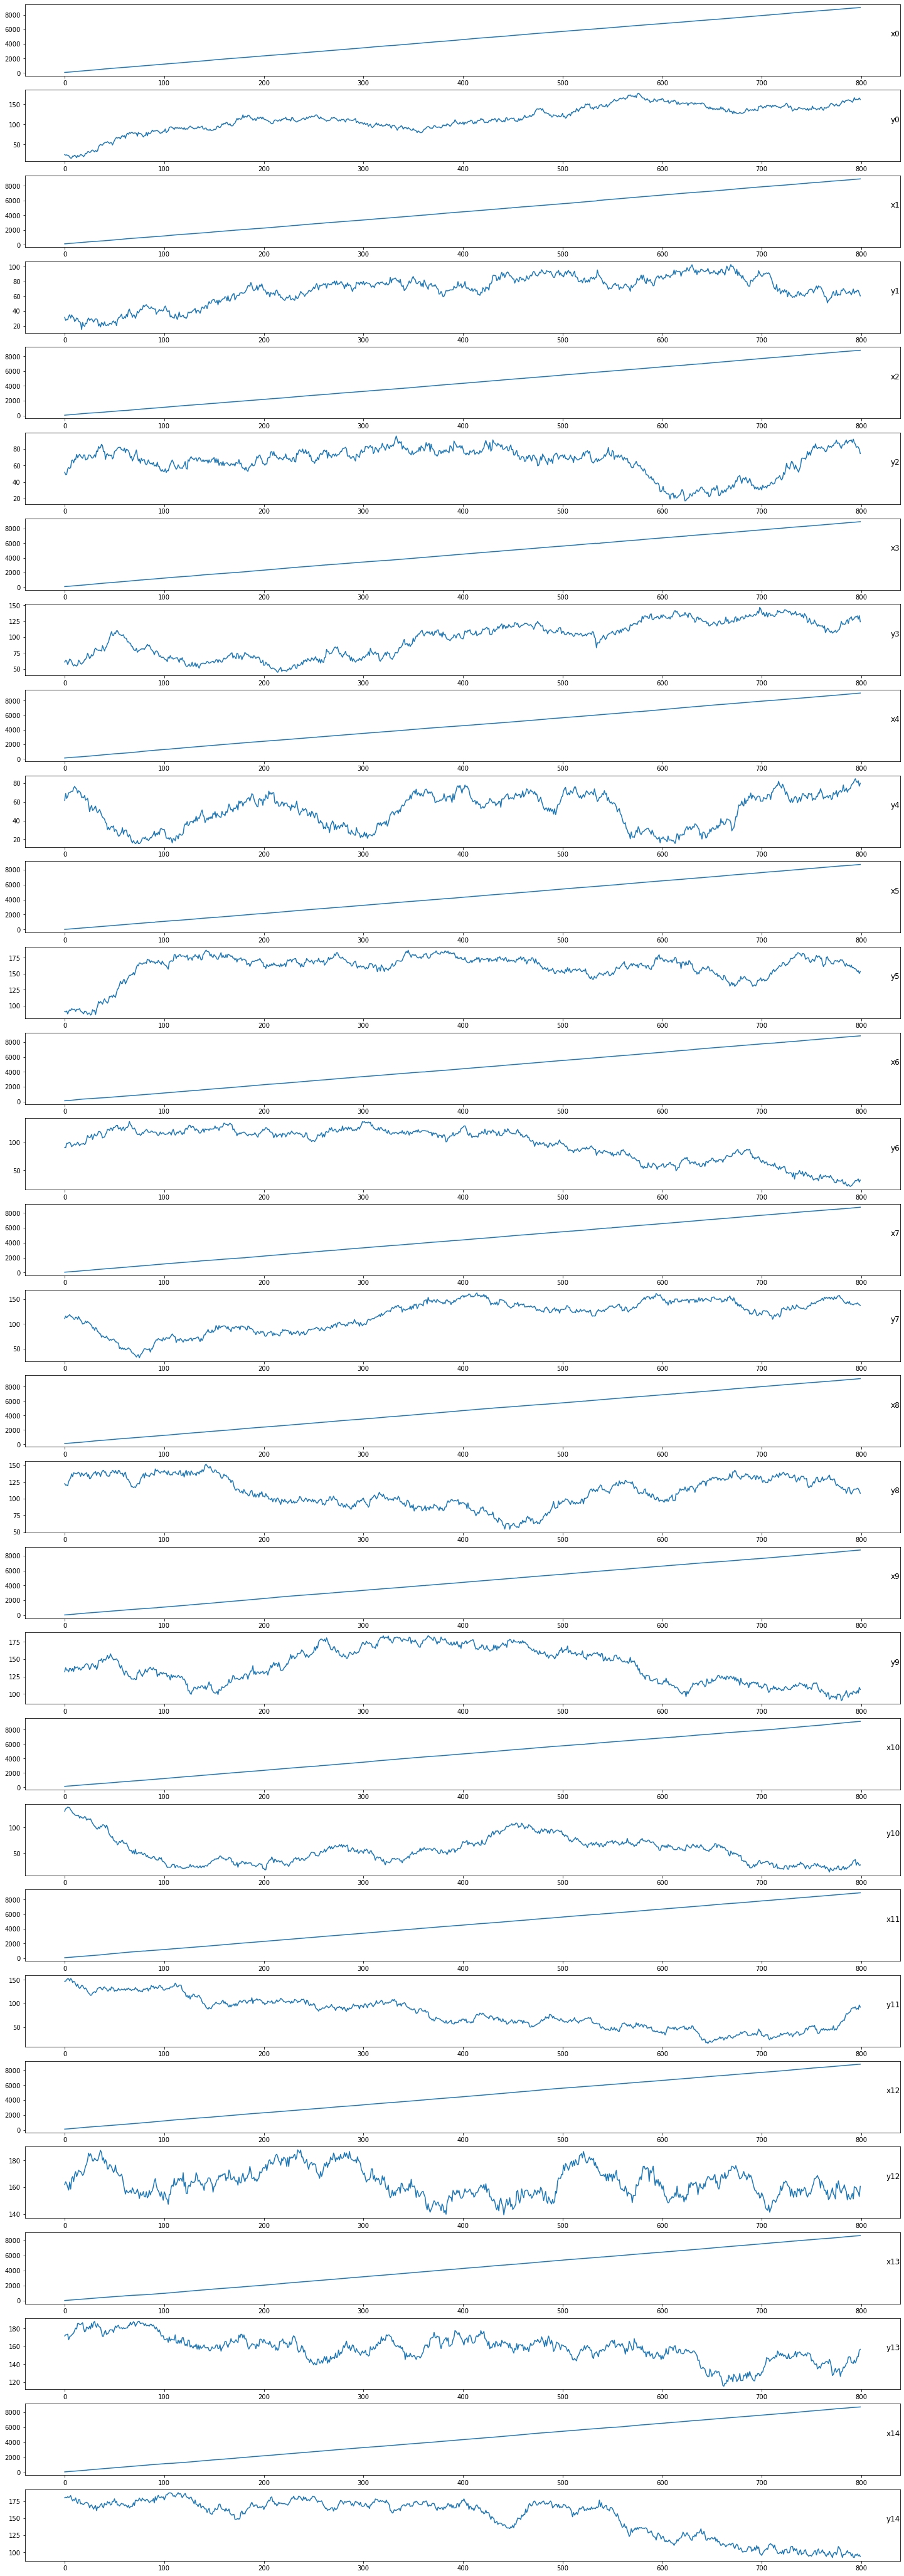

In [26]:
values = df.values
groups = list(range(2*no_skyrmions))
i = 1

plt.figure(figsize=(25, 5*no_skyrmions))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
    
plt.show()

In [27]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [28]:
from sklearn.preprocessing import MinMaxScaler

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
past = 1
future = 1
reframed = series_to_supervised(scaled, past, future)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var21(t),var22(t),var23(t),var24(t),var25(t),var26(t),var27(t),var28(t),var29(t),var30(t)
1,0.000000,0.054454,0.000000,0.187212,0.000000,0.440842,0.000000,0.158169,0.000000,0.667986,...,0.000691,0.973301,0.001423,0.959625,0.000858,0.509076,0.001213,0.791374,0.001405,0.929422
2,0.001002,0.044384,0.000681,0.139759,0.001796,0.405418,0.001325,0.181700,0.001448,0.771623,...,0.002611,0.981916,0.002552,0.983119,0.002110,0.478576,0.002600,0.791854,0.002721,0.922816
3,0.001865,0.050615,0.002453,0.154995,0.003275,0.409422,0.002493,0.174229,0.002262,0.696686,...,0.003606,1.000000,0.003788,0.996549,0.002449,0.426494,0.004037,0.801693,0.003158,0.937925
4,0.003415,0.042623,0.003653,0.152880,0.003919,0.491885,0.003856,0.120868,0.003958,0.728295,...,0.004477,0.994518,0.004648,0.994521,0.004047,0.380342,0.005167,0.715189,0.004897,0.926691
5,0.004771,0.039817,0.005052,0.199635,0.005384,0.514760,0.005468,0.154853,0.005605,0.784036,...,0.005436,0.989245,0.006367,0.963386,0.005822,0.504297,0.005955,0.761895,0.006866,0.933681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.993377,0.898799,0.993120,0.586750,0.994311,0.874529,0.993066,0.854512,0.992454,1.000000,...,0.994558,0.105885,0.995012,0.525503,0.994611,0.414567,0.995180,0.390200,0.996023,0.033856
796,0.994525,0.907040,0.994942,0.576816,0.995186,0.825865,0.994581,0.852113,0.994906,0.959082,...,0.995505,0.148596,0.995555,0.541905,0.996240,0.365914,0.995833,0.455090,0.997373,0.055251
797,0.995487,0.902588,0.996691,0.605542,0.996006,0.835989,0.996388,0.869913,0.995963,0.942617,...,0.997305,0.134983,0.997767,0.525352,0.998091,0.345751,0.996526,0.455154,0.998006,0.025385
798,0.997425,0.905810,0.997270,0.600037,0.996892,0.828328,0.997530,0.820182,0.997304,0.969428,...,0.999096,0.102385,0.998534,0.591345,0.998040,0.281448,0.998118,0.551011,0.998969,0.043218


In [29]:
# split into train and test sets
last_20_pct = int(reframed.shape[0] * 0.8)
values = reframed.values
train = values[:last_20_pct, :]
test = values[last_20_pct:, :]

# split into input and outputs
train_X, train_y = train[:, :-future * 2 * no_skyrmions], train[:, -future * 2 * no_skyrmions:]
test_X, test_y = test[:, :-future * 2 * no_skyrmions], test[:, -future * 2 * no_skyrmions:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(639, 1, 30) (639, 30) (160, 1, 30) (160, 30)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                4050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
Total params: 5,580
Trainable params: 5,580
Non-trainable params: 0
_________________________________________________________________
Train on 639 samples, validate on 160 samples
Epoch 1/100
639/639 [==============================] - 0s 301us/step - loss: 0.2263 - val_loss: 0.3515
Epoch 2/100
639/639 [==============================] - 0s 27us/step - loss: 0.2153 - val_loss: 0.3506
Epoch 3/100
639/639 [==============================] - 0s 27us/step - loss: 0.2075 - val_loss: 0.3480
Epoch 4/100
639/639 [========

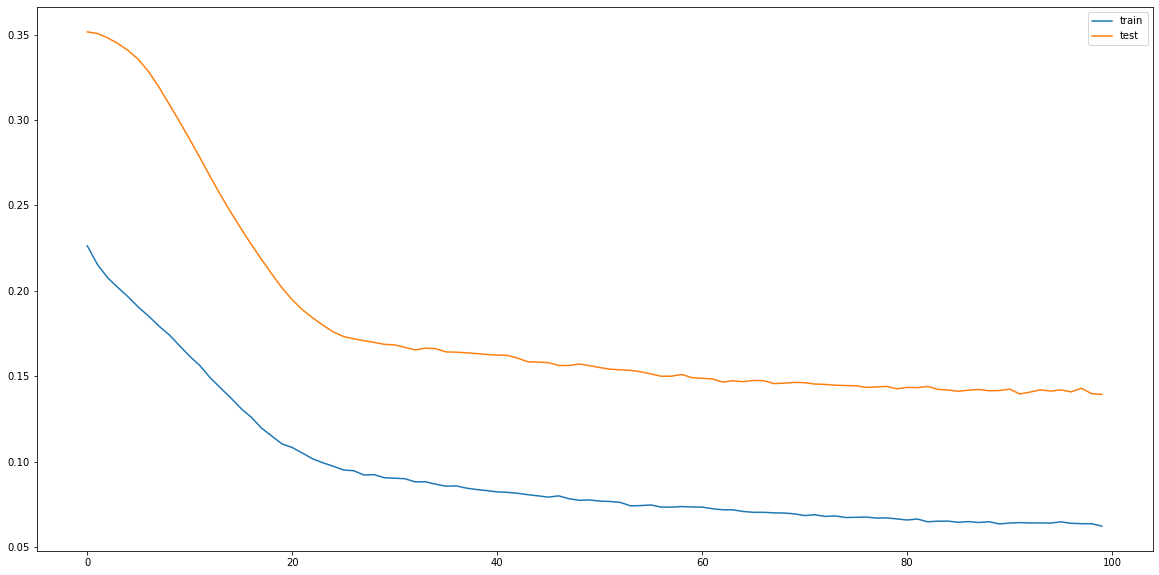

In [30]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from keras.regularizers import l2

# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

model.add(Dense(future * 2 * no_skyrmions, activation='sigmoid'))

model.summary()

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), future * 2 * no_skyrmions))
inv_y = np.concatenate((test_y_reshaped, test_X_reshaped[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = np.sqrt(mean_squared_error(inv_yhat, inv_y))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (160,59) (30,) (160,59) 